# Run network creation in parallel.

Please first start ```ipcluster```, on linux you type the following into the terminal, note that you should be in the ```Snudda/examples/notebook``` directory:

```
export IPYTHONDIR="`pwd`/.ipython"
export IPYTHON_PROFILE=default
ipcluster start 
```

These commands are in ```start_ipcluster.sh``` in the ```examples/notebook``` directory. After starting ipcluster give it a few seconds to get fully up and running before proceeding with the rest of the commands in this notebook. 

If you restart the run you might need to do:

```
ipcluster stop
ipcluster start
```

For instructions how to install and activate ipyparallel for your notebook see 
https://github.com/ipython/ipyparallel


The instructions above are created on Linux. If you run on **Windows** and do not get the environment variables to work for ipcluster, then you might need to update ```IPYTHONDIR``` in cell 1, and ```u_file``` in cell 3 to point to the location that ipcluster writes the pid file to.

In [1]:
import os

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

In [2]:
from snudda import SnuddaInit

network_path = os.path.join("networks","simple_example_parallel")
cnc = SnuddaInit(struct_def={}, network_path=network_path, random_seed=123)
cnc.define_striatum(num_dSPN=200, num_iSPN=200, num_FS=4, num_LTS=0, num_ChIN=0,
                    volume_type="cube", neurons_dir="$DATA/neurons")
cnc.write_json()

Using cube for striatum
Adding neurons: FSN from dir $DATA/neurons/striatum/fs
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing networks/simple_example_parallel/network-config.json


In [3]:
from ipyparallel import Client
u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
rc = Client(url_file=u_file, timeout=120, debug=False)
d_view = rc.direct_view(targets='all')  # rc[:] # Direct view into clients

Passing valid rc parameter to SnuddaDetect will lead to parallel execution.
When we use network_path as parameter we assume the config file is located in that directory and that it is named ```network-config.json```

In [4]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, rc=rc)
sp.parse_config()
sp.write_data()

In [5]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc)
sd.detect()

importing SnuddaDetect from snudda.detect.detect on engine(s)
Suppressing printouts for hyper voxels that complete in < 100 seconds.
HyperID 25 completed - 1321586 synapses found (186.2 s)


In the folder ```networks/simple_example_parallel/log/``` you can find log files for touch detection. The file ```logFile-touch-detection.txt``` is the master node log, and the files ```logFile-touch-detection.txt-0``` up to ```n``` are the different worker logs where you can see what they are doing, since they do not print their output to stdout.

In [6]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc)
sp.prune()

importing SnuddaPrune from snudda.detect.prune on engine(s)
There are few synapses, we will run it in serial instead
Synapses before pruning: 1404094
Synapses after pruning: 82529 (5.88 % kept)
Gap junctions before pruning 16
Gap junctions after pruning 7 (43.75 % kept)


Loading 404 neurons with 82529 synapses and 7 gap junctions


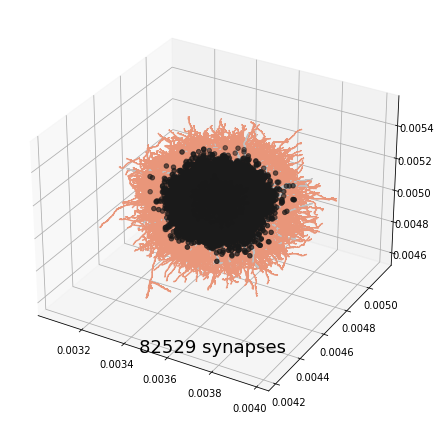

In [8]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-synapses.hdf5")
pn = PlotNetwork(network_file)
pn.plot()
pn.close()  # Close the hdf5 file so others can use it